In [1]:
push!(LOAD_PATH, "/Users/farr/Documents/Research/GaussianNoiseModeling/PopeFilters/code")

3-element Array{ByteString,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.4"     
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.4"           
 "/Users/farr/Documents/Research/GaussianNoiseModeling/PopeFilters/code"

In [2]:
using Ensemble
using Kalman
using PyCall
using PyPlot

In [3]:
@pyimport seaborn
seaborn.set_style("ticks")

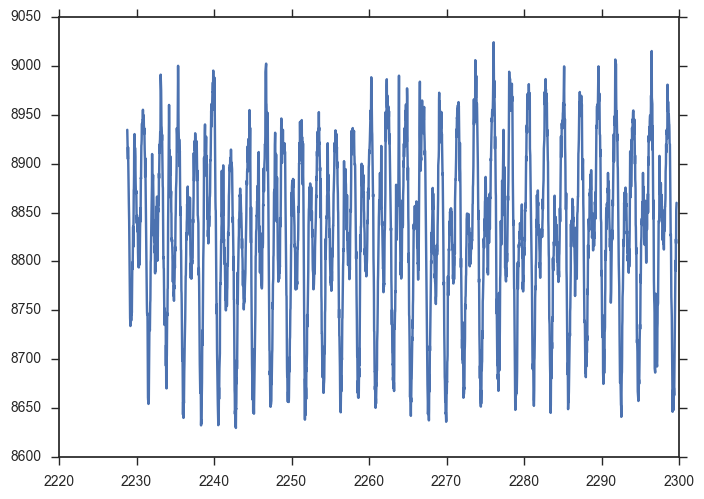

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324380650>

In [4]:
lc = readdlm("../epic211098454.txt")
plot(lc[:,1], lc[:,2])

In [5]:
ns54 = open(deserialize, "state-5-4.dat", "r")
ps54 = EnsembleNest.postsample(ns54)
nps54 = size(ps54, 2)
post54 = Kalman.CARMAKalmanPosterior(lc[:,1], lc[:,2], lc[:,3], 5, 4)
size(ps54)

(12,6413)

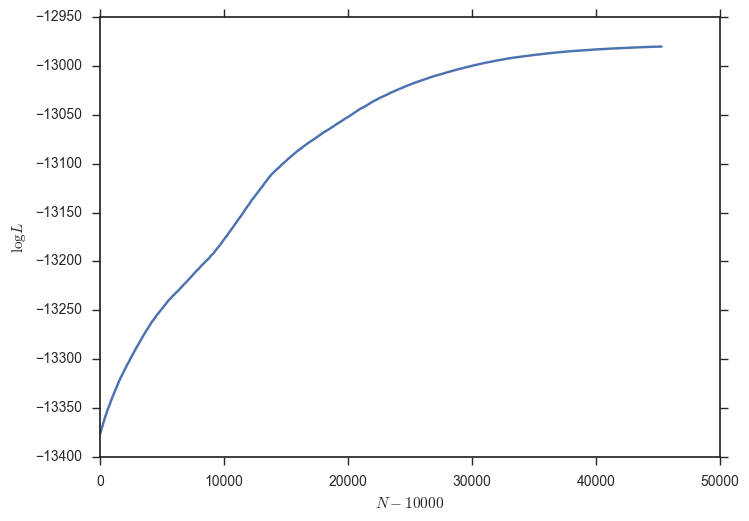

PyObject <matplotlib.text.Text object at 0x3228010d0>

In [6]:
plot(ns54.deadlogls[10000:end])
xlabel(L"$N-10000$")
ylabel(L"$\log L$")

In [7]:
dtmed = median(diff(lc[:,1]))
fmax = 1.0/(2.0*dtmed)
df = 1.0/(maximum(lc[:,1]) - minimum(lc[:,1]))
fs = collect(df:df:fmax)
nfs = size(fs, 1)
psds = zeros(nfs, 1024)
for i in 1:1024
    psds[:,i] = Kalman.psd(post54, ps54[:, rand(1:nps54)], fs)
end

In [8]:
pmin = zeros(nfs)
pmax = zeros(nfs)
pmed = zeros(nfs)
for i in 1:nfs
    pmin[i] = quantile(vec(psds[i,:]), 0.16)
    pmed[i] = median(vec(psds[i,:]))
    pmax[i] = quantile(vec(psds[i,:]), 0.84)
end

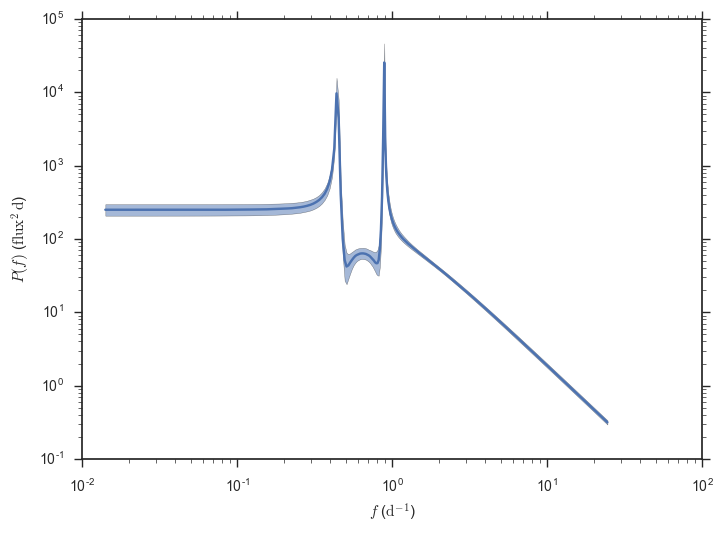

In [9]:
plot(fs, pmed)
fill_between(fs, pmax, pmin, alpha=0.5)
xlabel(L"$f$ ($\mathrm{d}^{-1}$)")
ylabel(L"$P(f)$ ($\mathrm{flux}^2 \, \mathrm{d}$)")
xscale("log")
yscale("log")

In [17]:
freqs = []
fwhms = []
for i in 1:nps54
    arroots = Kalman.to_params(post54, ps54[:,i]).arroots
    sel = imag(arroots) .> 0
    if countnz(sel) == 2
        push!(freqs, imag(arroots[sel])/(2.0*pi))
        push!(fwhms, -real(arroots[sel])/pi)
    end
end
freqs = hcat(freqs...) # make it 2D array, size (2, nfreqs)
fwhms = hcat(fwhms...)
nfreqs = size(freqs, 2)
periods = 1.0 ./ freqs
pmins = vec(minimum(periods, 1))
pmaxs = vec(maximum(periods, 1))

6413-element Array{Float64,1}:
 2.25331
 2.24593
 2.25426
 2.244  
 2.23696
 2.23368
 2.24678
 2.25847
 2.25383
 2.25889
 2.25109
 2.24804
 2.27053
 ⋮      
 2.258  
 2.25604
 2.24463
 2.24874
 2.25877
 2.25141
 2.24824
 2.25837
 2.25116
 2.24769
 2.25773
 2.25407

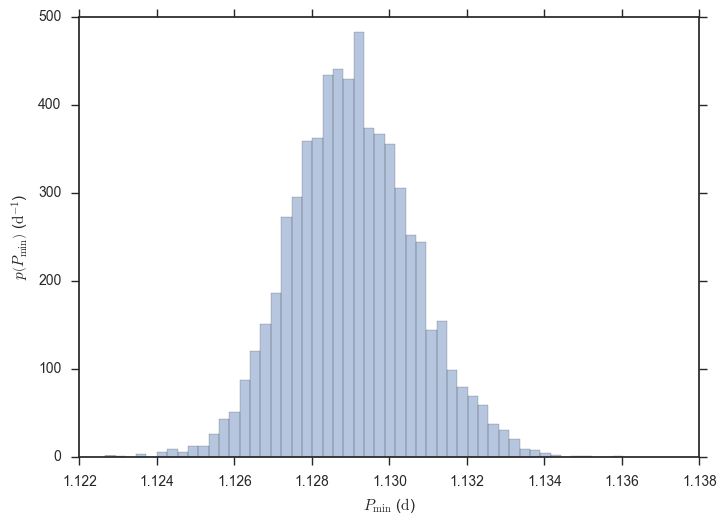

PyObject <matplotlib.text.Text object at 0x3272cc390>

In [11]:
seaborn.distplot(pmins, kde=false)
xlabel(L"$P_\mathrm{min}$ ($\mathrm{d}$)")
ylabel(L"$p\left( P_\mathrm{min} \right)$ ($\mathrm{d}^{-1}$)")

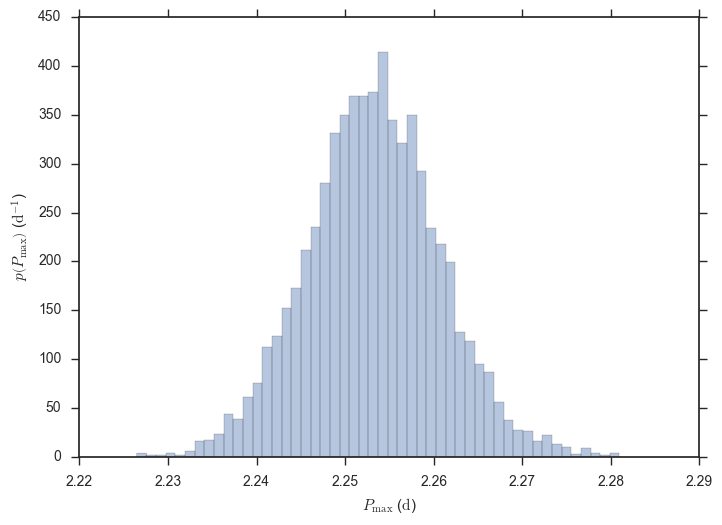

PyObject <matplotlib.text.Text object at 0x3279a0950>

In [12]:
seaborn.distplot(pmaxs, kde=false)
xlabel(L"$P_\mathrm{max}$ ($\mathrm{d}$)")
ylabel(L"$p\left( P_\mathrm{max} \right)$ ($\mathrm{d}^{-1}$)")

How about their ratio?

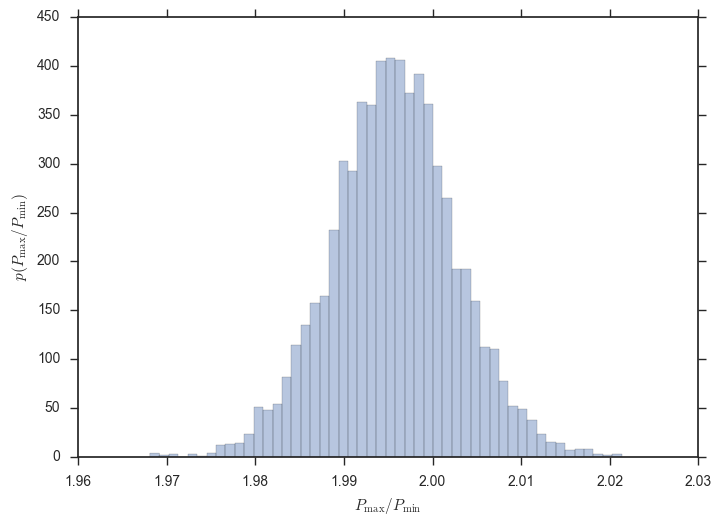

PyObject <matplotlib.text.Text object at 0x3279d1c90>

In [13]:
seaborn.distplot(pmaxs ./ pmins, kde=false)
xlabel(L"$P_\mathrm{max} / P_\mathrm{min}$")
ylabel(L"$p\left( P_\mathrm{max} / P_\mathrm{min} \right)$")

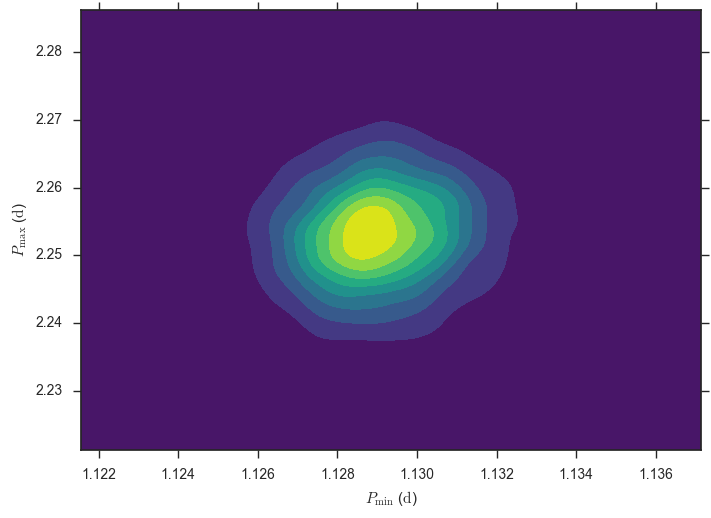

PyObject <matplotlib.text.Text object at 0x3260a7690>

In [14]:
seaborn.kdeplot(pmins, pmaxs, shade=true, cmap="viridis")
xlabel(L"$P_\mathrm{min}$ ($\mathrm{d}$)")
ylabel(L"$P_\mathrm{max}$ ($\mathrm{d}$)")

What about the width of the modes?  The fractional width is inversely proportional to $Q$, but maybe it is interesting to look at the FWHM; 1/FWHM gives a timescale over which the oscillation is coherent; we will also plot that.

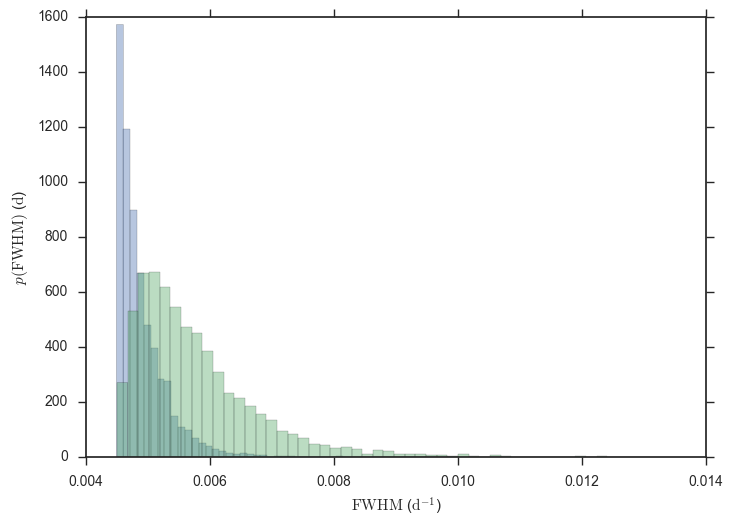

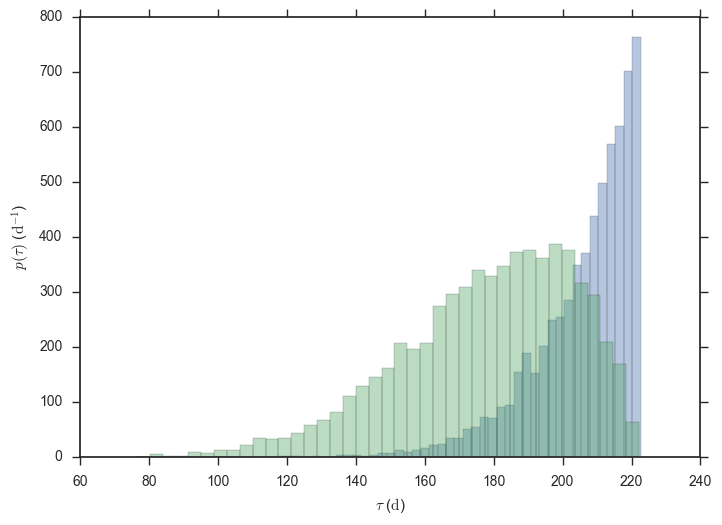

PyObject <matplotlib.text.Text object at 0x328e4ea90>

In [19]:
seaborn.distplot(vec(fwhms[1,:]), kde=false)
seaborn.distplot(vec(fwhms[2,:]), kde=false)
xlabel(L"$\mathrm{FWHM}$ ($\mathrm{d}^{-1}$)")
ylabel(L"$p(\mathrm{FWHM})$ ($\mathrm{d}$)")
figure()
seaborn.distplot(1.0./vec(fwhms[1,:]), kde=false)
seaborn.distplot(1.0./vec(fwhms[2,:]), kde=false)
xlabel(L"$\tau$ ($\mathrm{d}$)")
ylabel(L"$p(\tau)$ ($\mathrm{d}^{-1}$)")

How does this compare to the sampling resolution?  Our prior is that $\mathrm{FWHM} > (\pi T)^{-1}$, and you can see above that the smaller width mode is butting up against that prior.

In [21]:
println("T = $((maximum(lc[:,1]) - minimum(lc[:,1]))) d")

T = 70.87772432564816 d
